<a href="https://colab.research.google.com/github/LOGANAYAGISASI/Detr_Vehicle_Detection/blob/main/Train_detr_resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.0.1+cu118 True


In [ ]:
from PIL import Image

In [ ]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 323.68 KiB | 1.81 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r101_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth
100%|██████████| 232M/232M [00:09<00:00, 25.1MB/s]


## Prepare the dataset for fine-tuning




In [ ]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Object_detection_DETR/AU-INV-P.v9i.coco.zip -d /content/dataset/

Archive:  /content/drive/MyDrive/Object_detection_DETR/AU-INV-P.v9i.coco.zip
 extracting: /content/dataset/README.dataset.txt  
 extracting: /content/dataset/README.roboflow.txt  
   creating: /content/dataset/test/
 extracting: /content/dataset/test/1102_jpg.rf.c0c42e164d28a3f3bbbb3dfef16f4a2c.jpg  
 extracting: /content/dataset/test/12_jpg.rf.ed46cd81a704174b2d7fc7da0a8d09df.jpg  
 extracting: /content/dataset/test/1679389202315_jpg.rf.62f8c23aee8f54d65044c0d84677daf4.jpg  
 extracting: /content/dataset/test/1679389202324_jpg.rf.e1e5100e86b00a7151b83b0bd7731e9d.jpg  
 extracting: /content/dataset/test/1679389316474_jpg.rf.2f8aaa780d8edfa714d1834952c5b34e.jpg  
 extracting: /content/dataset/test/1679389428046_jpg.rf.46e502a1e9ca602ae3a04928b229f149.jpg  
 extracting: /content/dataset/test/1679389515984_jpg.rf.004a1bf981e2e5786db1f627153c9394.jpg  
 extracting: /content/dataset/test/1679389742889_jpg.rf.245298209eb060aef094c1770135818d.jpg  
 extracting: /content/dataset/test/167964859

In [ ]:
categories = ['AutoRikshaw', 'Bike', 'Bus', 'Car', 'Maxi Cab', 'Mini Truck', 'Truck']
super_categories = ['None','Vehicles']

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [ ]:
!mkdir -p /content/data/custom/annotations/



In [ ]:
!mv /content/dataset/train/_annotations.coco.json /content/data/custom/annotations/custom_train.json


In [ ]:
!mv /content/dataset/valid/_annotations.coco.json /content/data/custom/annotations/custom_val.json



In [ ]:
!mkdir -p /content/data/custom/train2017/



In [ ]:
!mv /content/dataset/train/*.jpg /content/data/custom/train2017/


In [ ]:

!mkdir -p /content/data/custom/val2017/



In [ ]:
!mv /content/dataset/valid/*.jpg /content/data/custom/val2017/

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:


In [ ]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
dataDir='/content/data/custom/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['Vehicles', 'AutoRikshaw', 'Bike', 'Bus', 'Car', 'Maxi Cab', 'Mini Truck', 'Truck']
Super-categories: {'none', 'Vehicles'}


In [ ]:
# load and display image
catIds = coco.getCatIds(catNms=['AutoRikshaw']);
imgIds = coco.getImgIds(catIds=catIds );

In [ ]:
imgIds

[2048,
 4097,
 2051,
 4100,
 2053,
 2056,
 10,
 2058,
 4106,
 4110,
 4111,
 2067,
 4117,
 22,
 4120,
 25,
 26,
 27,
 4121,
 2077,
 4128,
 2082,
 4130,
 36,
 4131,
 40,
 41,
 4137,
 43,
 2091,
 4143,
 51,
 2099,
 2102,
 55,
 2104,
 4150,
 2107,
 2108,
 4156,
 4162,
 67,
 4164,
 69,
 2121,
 2124,
 4174,
 2131,
 2132,
 4087,
 4182,
 88,
 4185,
 2138,
 2141,
 96,
 97,
 2148,
 4197,
 103,
 4199,
 105,
 2153,
 2154,
 4202,
 4205,
 110,
 2160,
 115,
 2163,
 2167,
 2173,
 2174,
 2175,
 4224,
 2181,
 134,
 2183,
 139,
 2188,
 144,
 2193,
 149,
 2199,
 158,
 159,
 162,
 2210,
 165,
 2220,
 2222,
 176,
 2225,
 2229,
 189,
 193,
 194,
 203,
 204,
 2251,
 2253,
 211,
 2262,
 218,
 2268,
 2276,
 2277,
 2278,
 233,
 235,
 2283,
 237,
 2287,
 240,
 2292,
 248,
 2297,
 2298,
 2299,
 2300,
 253,
 254,
 255,
 257,
 2306,
 261,
 267,
 2317,
 2319,
 2320,
 2323,
 2324,
 284,
 2332,
 291,
 292,
 2339,
 2340,
 2343,
 296,
 2344,
 2345,
 299,
 2347,
 2349,
 2352,
 2354,
 307,
 2356,
 309,
 311,
 2360,
 2364,


Image n°2210
Image name: /content/data/custom//train2017/1679389428057_jpg.rf.cf6d10f9c240975a74c6e7ad2addf3b2.jpg


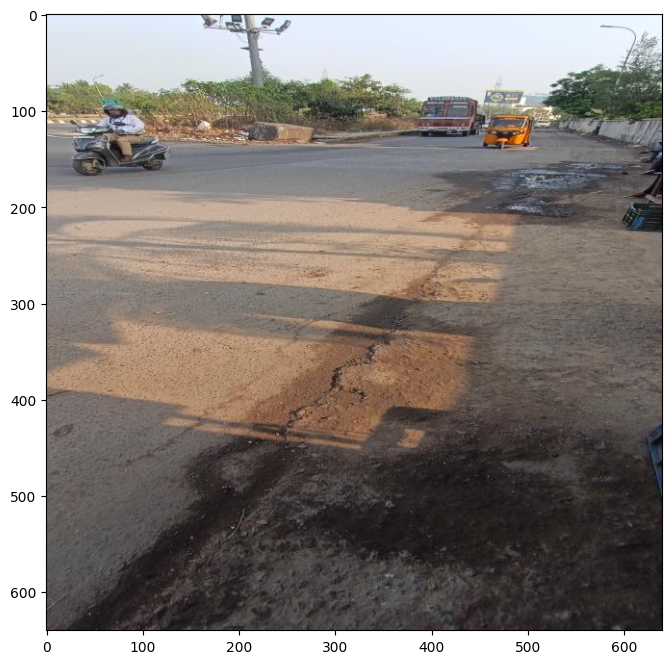

In [ ]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [ ]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

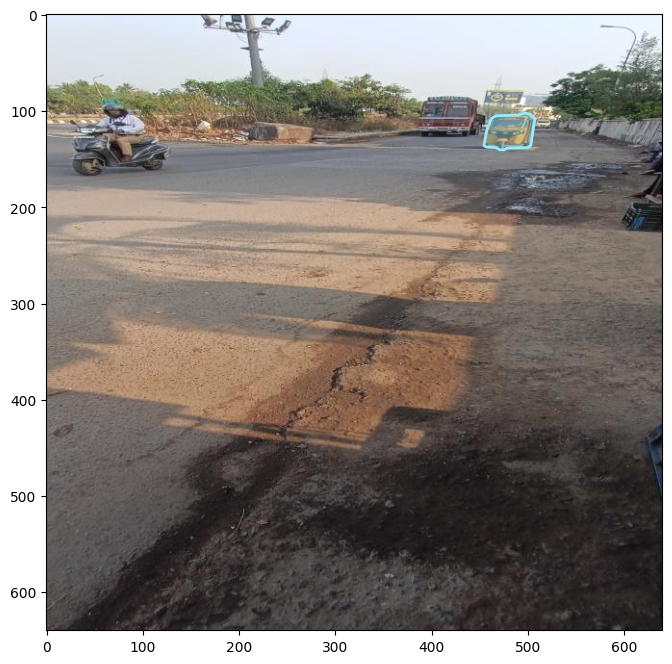

In [ ]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

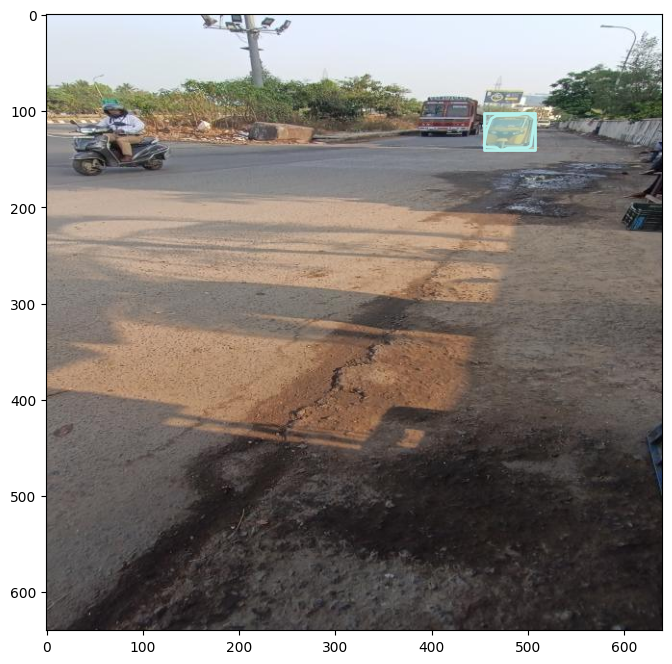

In [ ]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

In [ ]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, with ID n°0.

  num_classes = 8

  finetuned_classes = [
      'None','AutoRikshaw', 'Bike', 'Bus', 'Car', 'Maxi Cab', 'Mini Truck', 'Truck'
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 8

  finetuned_classes = [
     'AutoRikshaw', 'Bike', 'Bus', 'Car', 'Maxi Cab', 'Mini Truck', 'Truck','None'
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 8
Fine-tuned classes: ['None', 'AutoRikshaw', 'Bike', 'Bus', 'Car', 'Maxi Cab', 'Mini Truck', 'Truck']


In [ ]:
%cd /content/detr/

/content/detr


In [ ]:
!python main.py \
  --dataset_file "custom" \
  --backbone "resnet101" \
  --coco_path "/content/data/custom/" \
  --output_dir "outputs" \
  --resume "detr-r101_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10

Not using distributed mode
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet101', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=8, dataset_file='custom', coco_path='/content/data/custom/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr-r101_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The par

In [ ]:
mv /content/detr/outputs/checkpoint.pth /content/drive/MyDrive/Object_detection_DETR